In [ ]:
# pip install esm
# pip install git+https://github.com/OrthoFinder/OrthoFinder.git

In [ ]:
!orthofinder -f EvoCluster/Sample_TestCase


2025-08-14 09:20:56 : Starting OrthoFinder v3.1.0.post1.dev3
2 thread(s) for highly parallel tasks (BLAST searches etc.)
1 thread(s) for OrthoFinder algorithm

OrthoFinder version 3.1.0.post1.dev3 Copyright (C) 2014 David Emms

Results directory:
    /content/drive/MyDrive/ColabNotebooks/Sample_TestCase/OrthoFinder/Results_Au
g14_2/

Checking required programs are installed
Running with the recommended MSA tree inference by default. To revert to legacy 
method use "-M dendroblast".

Test can run "mcl" - ok
Test can run "famsa" - ok
Test can run "fasttree" - ok

Dividing up work for BLAST for parallel processing
--------------------------------------------------
Processing... ━   3/3 0:00:00

Running diamond all-versus-all
Using 2 thread(s)
2025-08-14 09:20:58 : This may take some time...
Processing... ━   9/9 0:00:21
2025-08-14 09:21:19 : Done all-versus-all sequence search

Running OrthoFinder algorithm
-----------------------------
2025-08-14 09:21:19 : Initial processing of each sp

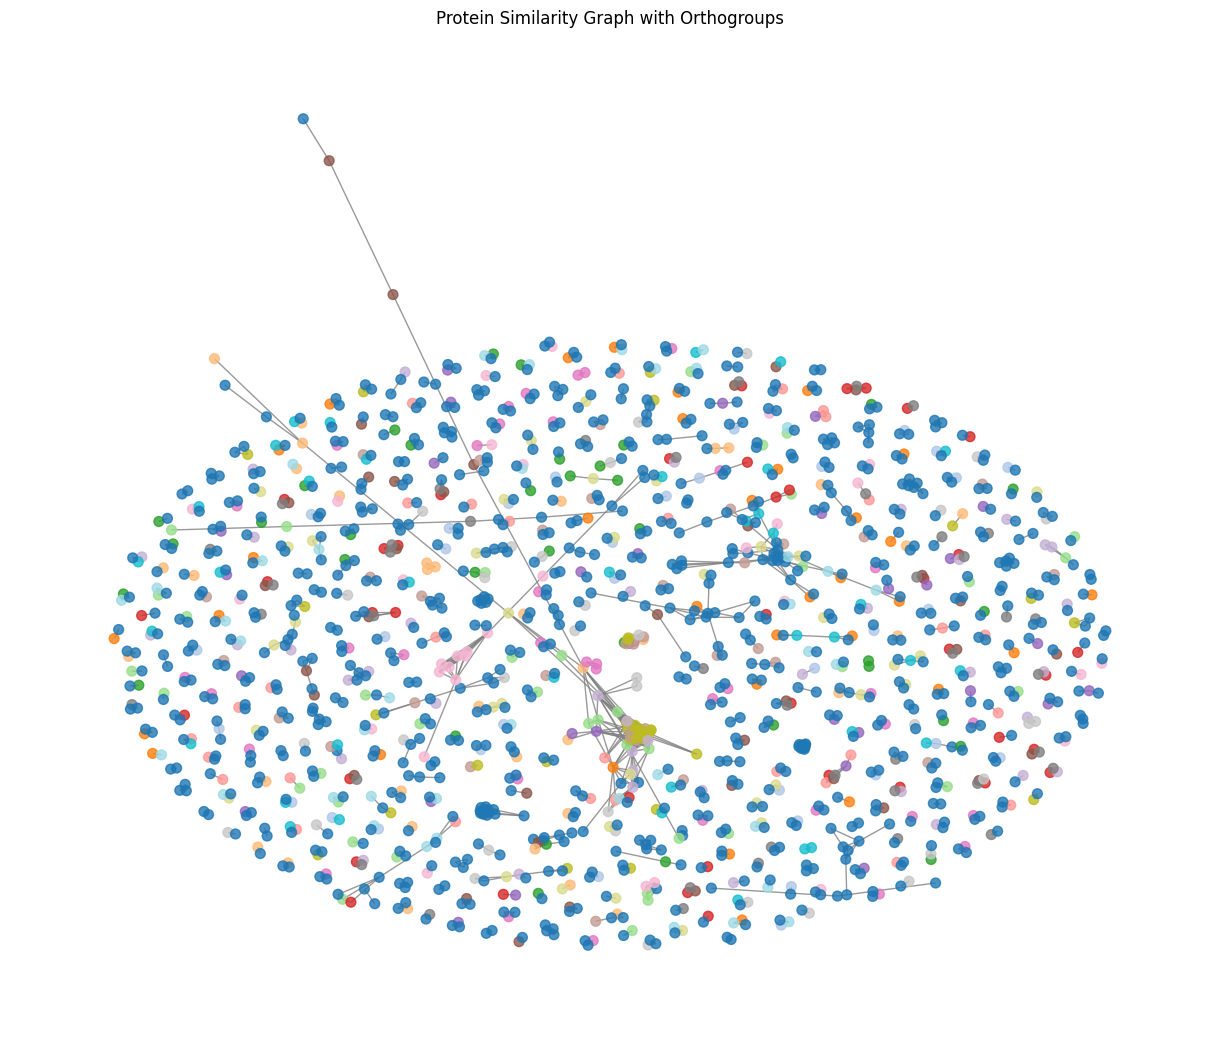

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def parse_mcl_clusters(filename):
    """
    Parse OrthoFinder clusters_Orthogroups.txt file.
    Returns dict: node -> orthogroup_id
    """
    node_to_group = {}
    with open(filename, "r") as f:
        inside_matrix = False
        group_id = 0
        for line in f:
            line = line.strip()
            if line.startswith("(mclmatrix"):
                inside_matrix = True
                continue
            if inside_matrix:
                if line == ")":  # end of matrix
                    break
                if line.startswith("begin") or not line:
                    continue
                # Split on spaces, remove '$'
                parts = line.replace("$","").split()
                group_id += 1
                for node in parts:
                    node_to_group[node] = group_id
    return node_to_group

def parse_mcl_graph(filename):
    """
    Parse OrthoFinder graph file into an edge list.
    """
    edges = []
    with open(filename, "r") as f:
        inside_matrix = False
        for line in f:
            line = line.strip()
            if line.startswith("(mclmatrix"):
                inside_matrix = True
                continue
            if inside_matrix:
                if line == ")":  # end of matrix
                    break
                if line.startswith("begin") or not line:
                    continue

                parts = line.split()
                node = parts[0]
                for p in parts[1:]:
                    if p == "$":
                        continue
                    target, weight = p.split(":")
                    edges.append((node, target, float(weight)))
    return edges

def visualize_graph(edges, node_to_group, max_nodes=200):
    """
    Visualize graph with nodes colored by orthogroup.
    """
    G = nx.Graph()
    for u, v, w in edges:
        G.add_edge(u, v, weight=w)

    # Restrict graph size if needed
    if len(G.nodes) > max_nodes:
        largest_cc = max(nx.connected_components(G), key=len)
        sub_nodes = list(largest_cc)[:max_nodes]
        G = G.subgraph(sub_nodes).copy()

    # Assign colors by orthogroup
    groups = [node_to_group.get(n, -1) for n in G.nodes()]
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42, weight="weight")
    nx.draw(
        G, pos,
        node_size=50,
        node_color=groups,
        cmap=plt.cm.tab20,  # color palette
        edge_color="gray",
        with_labels=False,
        alpha=0.8
    )
    plt.title("Protein Similarity Graph with Orthogroups")
    plt.show()

# ---------- Run ----------
graph_file = "/content/EvoCluster/Sample_TestCase/OrthoFinder/Results_Aug14_2/WorkingDirectory/OrthoFinder_graph.txt"     # graph file
clusters_file = "/content/EvoCluster/Sample_TestCase/OrthoFinder/Results_Aug14_2/WorkingDirectory/clusters_OrthoFinder_I1.2.txt_id_pairs.txt"  # clusters file

edges = parse_mcl_graph(graph_file)
node_to_group = parse_mcl_clusters(clusters_file)
visualize_graph(edges, node_to_group, max_nodes=2000)


In [1]:
import pandas as pd
from Bio import SeqIO
import os

# Define file paths
# NOTE: In a real-world scenario, ensure these files exist at the specified paths.
ORTHOGROUP_FILE = './Sample_TestCase/OrthoFinder/Results_Aug14_2/Orthogroups/Orthogroups.txt'
file_path_agalactiae = './Sample_TestCase/Mycoplasma_agalactiae_5632_FP671138.faa'
file_path_genitalium = './Sample_TestCase/Mycoplasma_genitalium_uid97_L43967.faa'
file_path_hyopneumoniae = './Sample_TestCase/Mycoplasma_hyopneumoniae_AE017243.faa'

def get_sequence_details(gene_id, indices):
    """
    Searches for a gene ID in the appropriate FASTA file using a prefix-based heuristic.

    Args:
        gene_id (str): The gene ID to search for (e.g., 'gi|290752288|emb|CBH40259.1|').
        indices (dict): A dictionary of SeqIO.index objects for each organism.

    Returns:
        tuple: A tuple containing (organism_name, sequence) or (None, None) if not found.
    """
    # The 'emb' prefix is used as a heuristic to quickly search the correct file.
    # This avoids unnecessary lookups in other large files.
    if '|emb|' in gene_id:
        try:
            record = indices['agalactiae'][gene_id]
            organism_name = "Mycoplasma agalactiae"
            return organism_name, str(record.seq)
        except KeyError:
            # If not found in the primary file, a simple fallback to others can be added
            # though based on the heuristic, it's unlikely to be found elsewhere.
            pass
    else:
        # Search the other two files if the 'emb' prefix is not present.
        try:
            record = indices['genitalium'][gene_id]
            organism_name = "Mycoplasma genitalium"
            return organism_name, str(record.seq)
        except KeyError:
            try:
                record = indices['hyopneumoniae'][gene_id]
                organism_name = "Mycoplasma hyopneumoniae"
                return organism_name, str(record.seq)
            except KeyError:
                pass

    # If the gene ID is not found in any of the files, return None.
    return None, None

"""
Creates a pandas DataFrame from orthogroup and FASTA data.

This function reads gene IDs from an orthogroup file, uses Biopython to
efficiently search for sequence data in three FASTA files, and then
compiles the information into a DataFrame.
"""
print("Step 1: Parsing orthogroup file...")
orthogroup_data = {}
with open(ORTHOGROUP_FILE, 'r') as f:
    for line in f:
        parts = line.strip().split()
        orthogroup_id = parts[0].strip(':')
        gene_ids = parts[1:]
        orthogroup_data[orthogroup_id] = gene_ids

print("Step 2: Indexing FASTA files for efficient lookup...")
indices = {}
indices['agalactiae'] = SeqIO.index(file_path_agalactiae, "fasta")
indices['genitalium'] = SeqIO.index(file_path_genitalium, "fasta")
indices['hyopneumoniae'] = SeqIO.index(file_path_hyopneumoniae, "fasta")

print("Step 3: Populating DataFrame data...")
data = []
for orthogroup_id, gene_ids in orthogroup_data.items():
    for gene_id in gene_ids:
        # Get organism name and sequence using the defined helper function
        organism_name, seq = get_sequence_details(gene_id, indices)

        # Only add to the list if the gene was found
        if organism_name and seq:
            data.append([orthogroup_id, gene_id, organism_name, seq])
        else:
            print(f"Warning: Gene ID '{gene_id}' not found in any FASTA file.")
    if orthogroup_id == "OG0000005":
      break

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data, columns=['orthogroup_id', 'gene_id','organism_name','sequence'])

print("Step 4: Saving DataFrame to CSV...")
output_filename = 'orthogroup_data.csv'
df.to_csv(output_filename, index=False)
print(f"Successfully saved data to {output_filename}")
print(f"\nDataFrame head:\n{df.head()}")


Step 1: Parsing orthogroup file...
Step 2: Indexing FASTA files for efficient lookup...
Step 3: Populating DataFrame data...
Step 4: Saving DataFrame to CSV...
Successfully saved data to orthogroup_data.csv

DataFrame head:
  orthogroup_id                       gene_id          organism_name  \
0     OG0000000  gi|290752286|emb|CBH40257.1|  Mycoplasma agalactiae   
1     OG0000000  gi|290752287|emb|CBH40258.1|  Mycoplasma agalactiae   
2     OG0000000  gi|290752289|emb|CBH40260.1|  Mycoplasma agalactiae   
3     OG0000000  gi|290752399|emb|CBH40370.1|  Mycoplasma agalactiae   
4     OG0000000  gi|290752409|emb|CBH40380.1|  Mycoplasma agalactiae   

                                            sequence  
0  MKTKHKFFLIASSAPLLLTSIAASCTKNKNGNKNTPINSGNVVVSI...  
1  MFWAATSFNSKLGNWNVSNVKSMERMFADAHNFNQDISGWNVENVQ...  
2  MKIKKLLLITPFTSASIAFVAASCGKGDSAVPEIINTDASRIEIPA...  
3  MDKPADKPVDMPSDTPSDMPSDQGDQNSAPKIIKTDISKLKLDITS...  
4  MKKFKFMAFAIVAFIPPIPLIMAGCNNKSNNNSHNDDKNPKEKKLD...  


In [ ]:
from getpass import getpass

# token = getpass("Token from Forge console: ")
with open('secrets.txt','r') as f:
    token = f.readline().strip()

In [4]:
from esm.sdk import client

model = client(
    model="esmc-300m-2024-12", url="https://forge.evolutionaryscale.ai", token=token
)

In [5]:
from concurrent.futures import ThreadPoolExecutor
from typing import Sequence

from esm.sdk.api import (
    ESM3InferenceClient,
    ESMProtein,
    ESMProteinError,
    LogitsConfig,
    LogitsOutput,
    ProteinType,
)

EMBEDDING_CONFIG = LogitsConfig(
    sequence=True, return_embeddings=True, return_hidden_states=True
)


def embed_sequence(model: ESM3InferenceClient, sequence: str) -> LogitsOutput:
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.encode(protein)
    output = model.logits(protein_tensor, EMBEDDING_CONFIG)
    return output


def batch_embed(
    model: ESM3InferenceClient, inputs: Sequence[ProteinType]
) -> Sequence[LogitsOutput]:
    """Forge supports auto-batching. So batch_embed() is as simple as running a collection
    of embed calls in parallel using asyncio.
    """
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(embed_sequence, model, protein) for protein in inputs
        ]
        results = []
        for future in futures:
            try:
                results.append(future.result())
            except Exception as e:
                results.append(ESMProteinError(500, str(e)))
    return results

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

adk_path = "orthogroup_data.csv"
df = pd.read_csv(adk_path)
df = df[['orthogroup_id', 'gene_id','organism_name','sequence']]
df = df[df['sequence'].str.len() <= 2047]

In [ ]:
outputs = batch_embed(model, df["sequence"].tolist())

d:\Programming\Try\Lab\Major\env\Lib\site-packages\esm\utils\misc.py:275: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)


In [16]:
import torch

# we'll summarize the embeddings using their mean across the sequence dimension
# which allows us to compare embeddings for sequences of different lengths
# Filter out ESMProteinError objects before processing
all_mean_embeddings = [
    torch.mean(output.hidden_states, dim=-2).squeeze() for output in outputs
]

In [17]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

In [18]:
N_KMEANS_CLUSTERS = 6
def plot_embeddings_at_layer(all_mean_embeddings: torch.Tensor, layer_idx: int):
    stacked_mean_embeddings = torch.stack(
        [embedding[layer_idx, :] for embedding in all_mean_embeddings]
    ).to(torch.float32).numpy()

    # project all the embeddings to 2D using PCA
    pca = PCA(n_components=2)
    pca.fit(stacked_mean_embeddings)
    projected_mean_embeddings = pca.transform(stacked_mean_embeddings)

    # compute kmeans purity as a measure of how good the clustering is
    kmeans = KMeans(n_clusters=N_KMEANS_CLUSTERS, random_state=0).fit(
        projected_mean_embeddings
    )
    rand_index = adjusted_rand_score(df["orthogroup_id"], kmeans.labels_)

    # plot the clusters
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=projected_mean_embeddings[:, 0],
        y=projected_mean_embeddings[:, 1],
        hue=df["orthogroup_id"],
    )
    plt.title(
        f"PCA of mean embeddings at layer {layer_idx}.\nRand index: {rand_index:.2f}"
    )
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.savefig(f'results/plt_layer{layer_idx}.png')
    plt.show()

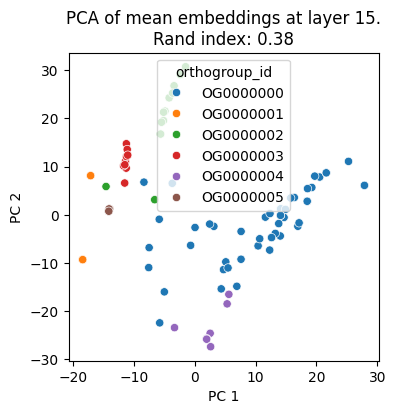

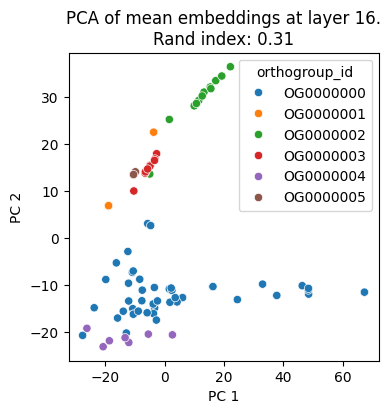

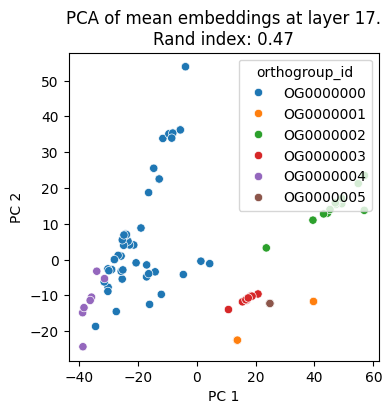

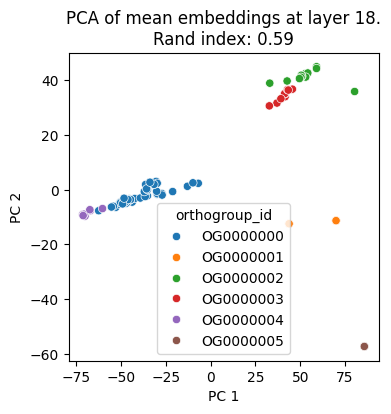

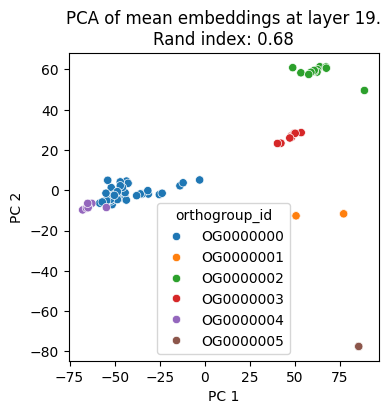

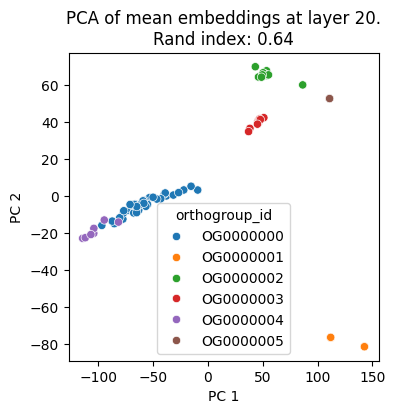

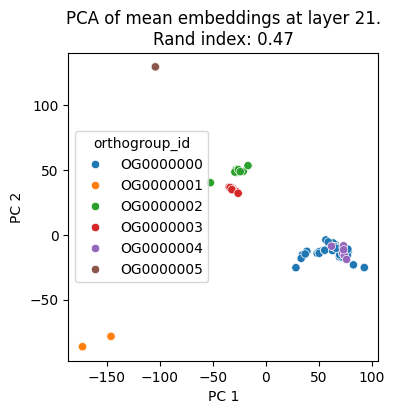

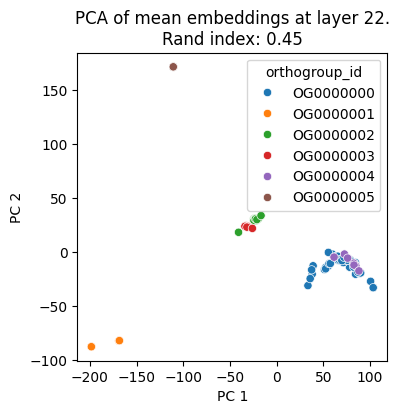

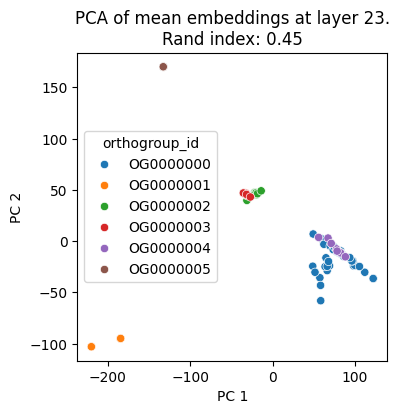

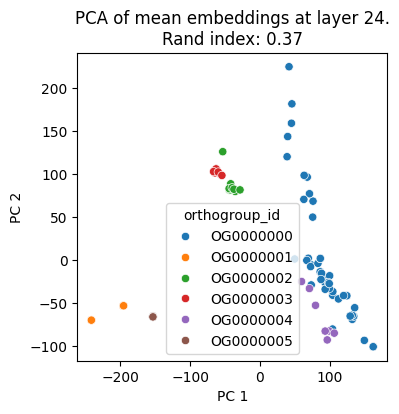

In [19]:
for i in os.listdir('results'):
    os.remove(f'results/{i}')
for i in range(15,25):
  plot_embeddings_at_layer(all_mean_embeddings, layer_idx=i)